In [ ]:
!pip install opencv-contrib-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 17.5 MB/s eta 0:00:00


Image Stitching for a pair of Images

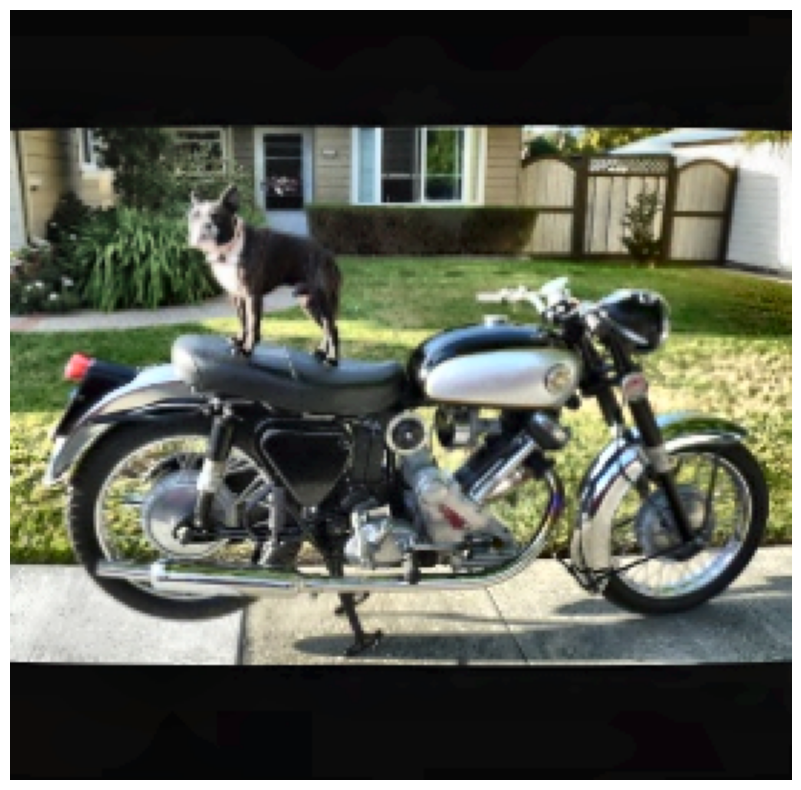

Panorama saved as '/content/panorama_enhanced.jpg'


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile

def extract_zip(zip_path, extract_to):
    """Extracts a ZIP file to a specified directory."""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def enhance_image(image):
    """Enhances brightness and color grading using histogram equalization."""
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    enhanced_lab = cv2.merge([l, a, b])
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    return enhanced_img

def stitch_images(images):
    """Stitches multiple images into a seamless panorama."""
    stitcher = cv2.Stitcher_create()
    status, panorama = stitcher.stitch(images)

    if status != cv2.Stitcher_OK:
        print("Error: Unable to stitch images")
        return None

    return enhance_image(panorama)

def main():
    zip_path = '/content/final (5).zip'  # Path to the ZIP file
    extract_to = '/content/extracted_images'  # Extraction folder

    # Extract images
    extract_zip(zip_path, extract_to)

    # Get list of image files in the extracted folder
    image_files = sorted([os.path.join(extract_to, f) for f in os.listdir(extract_to) if f.lower().endswith(('jpg', 'jpeg', 'png'))])

    if not image_files:
        print("Error: No images found in the ZIP file.")
        return

    images = [cv2.imread(file) for file in image_files]

    if any(img is None for img in images):
        print("Error: One or more images could not be loaded.")
        return

    # Convert images to RGB
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

    panorama = stitch_images(images)

    if panorama is not None:
        plt.figure(figsize=(15, 10))
        plt.imshow(panorama)
        plt.axis('off')
        plt.show()

        cv2.imwrite('/content/panorama_enhanced.jpg', cv2.cvtColor(panorama, cv2.COLOR_RGB2BGR))
        print("Panorama saved as '/content/panorama_enhanced.jpg'")

if __name__ == "__main__":
    main()


Retinal Image Stitching for only one pair

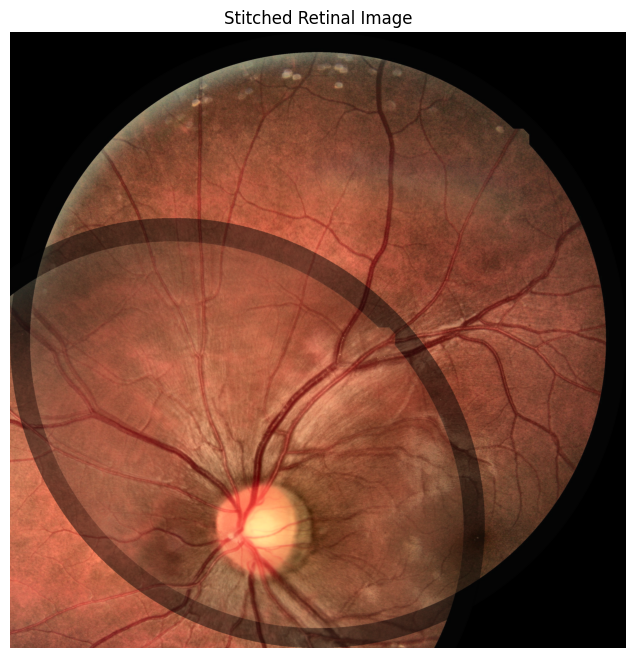

Stitched image saved as stitched_retinal_image.jpg


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

def preprocess_retinal_image(image):
    """Preprocessing specific to retinal images"""
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to enhance vessel contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge channels back
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

    # Preserve the circular mask of the retinal image
    # Create a circular mask
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    radius = min(w, h) // 2

    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, -1)

    # Apply mask to the enhanced image
    result = np.zeros_like(enhanced_img)
    for i in range(3):
        result[:, :, i] = cv2.bitwise_and(enhanced_img[:, :, i], mask)

    return result

def align_retinal_images(img1, img2):
    """Aligns retinal images using feature matching"""
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test to find good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Use homography to align if we have enough good matches
    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Apply transformation
        h, w = img1.shape[:2]
        aligned_img = cv2.warpPerspective(img1, H, (w, h))

        return aligned_img, img2
    else:
        print("Not enough matches found - returning original images")
        return img1, img2

def blend_retinal_images(img1, img2):
    """Blends two retinal images with special attention to the optic disc and vessels"""
    # Create masks for non-black regions
    mask1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY) > 0
    mask2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY) > 0

    # Intersection of the two masks is where we'll perform blending
    overlap_mask = mask1 & mask2

    # Create the blended image
    result = np.zeros_like(img1)

    # For non-overlapping regions, just copy the original pixel values
    result[mask1 & ~overlap_mask] = img1[mask1 & ~overlap_mask]
    result[mask2 & ~overlap_mask] = img2[mask2 & ~overlap_mask]

    # For overlapping regions, use alpha blending
    alpha = 0.5
    result[overlap_mask] = img1[overlap_mask] * alpha + img2[overlap_mask] * (1 - alpha)

    return result

def stitch_retinal_images(img1, img2):
    """Main function to stitch retinal images"""
    # Preprocess images
    preprocessed1 = preprocess_retinal_image(img1)
    preprocessed2 = preprocess_retinal_image(img2)

    # Align images
    aligned1, aligned2 = align_retinal_images(preprocessed1, preprocessed2)

    # Blend images
    stitched = blend_retinal_images(aligned1, aligned2)

    return stitched

def main():
    """Main function that loads images from files and processes them"""
    # SPECIFY YOUR IMAGE PATHS HERE - replace these with the actual paths to your files
    image_path1 = "/content/P14_1.jpg"  # Replace with your first image path
    image_path2 = "/content/P14_2.jpg"  # Replace with your second image path

    # Load images using OpenCV
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    # Check if images loaded correctly
    if img1 is None or img2 is None:
        print("Error: Could not load one or both images.")
        return

    # Convert to RGB (OpenCV loads as BGR)
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Stitch images
    stitched_image = stitch_retinal_images(img1_rgb, img2_rgb)

    # Display result
    plt.figure(figsize=(10, 8))
    plt.imshow(stitched_image)
    plt.axis('off')
    plt.title('Stitched Retinal Image')
    plt.show()

    # Save result
    output_path = "stitched_retinal_image.jpg"  # You can change this output filename
    cv2.imwrite(output_path, cv2.cvtColor(stitched_image, cv2.COLOR_RGB2BGR))
    print(f"Stitched image saved as {output_path}")

if __name__ == "__main__":
    main()

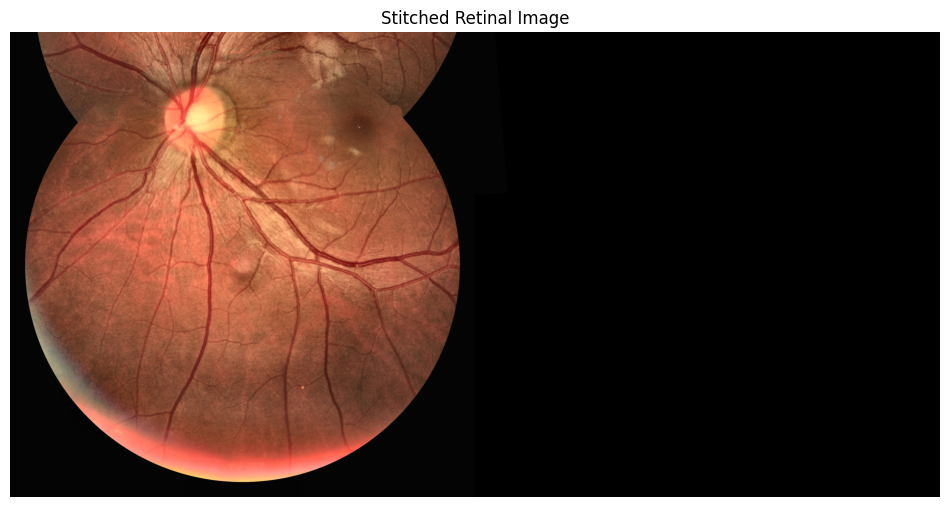

Stitched image saved successfully.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_retinal_image(image):
    """Preprocessing to enhance contrast in retinal images"""
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    return enhanced_img

def find_homography(img1, img2):
    """Finds the homography matrix to align two images"""
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H
    return None

def stitch_retinal_images(img1, img2):
    """Stitches two retinal images while preserving complete details"""
    preprocessed1 = preprocess_retinal_image(img1)
    preprocessed2 = preprocess_retinal_image(img2)
    H = find_homography(preprocessed1, preprocessed2)
    if H is not None:
        height1, width1 = preprocessed1.shape[:2]
        height2, width2 = preprocessed2.shape[:2]
        new_width = width1 + width2
        new_height = max(height1, height2)
        warped_img1 = cv2.warpPerspective(preprocessed1, H, (new_width, new_height))
        blended_image = np.maximum(warped_img1, cv2.copyMakeBorder(preprocessed2, 0, new_height - height2, 0, new_width - width2, cv2.BORDER_CONSTANT, value=[0, 0, 0]))
        return blended_image
    return None

def main():
    """Main function to load images and perform stitching"""
    image_path1 = "/content/P15_2.jpg"
    image_path2 = "/content/P15_1.jpg"
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)
    if img1 is None or img2 is None:
        print("Error: Could not load one or both images.")
        return
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    stitched_image = stitch_retinal_images(img1_rgb, img2_rgb)
    if stitched_image is not None:
        plt.figure(figsize=(12,10))
        plt.imshow(stitched_image)
        plt.axis('off')
        plt.title('Stitched Retinal Image')
        plt.show()
        cv2.imwrite("stitched_retinal_image.jpg", cv2.cvtColor(stitched_image, cv2.COLOR_RGB2BGR))
        print("Stitched image saved successfully.")
    else:
        print("Stitching failed.")

if __name__ == "__main__":
    main()


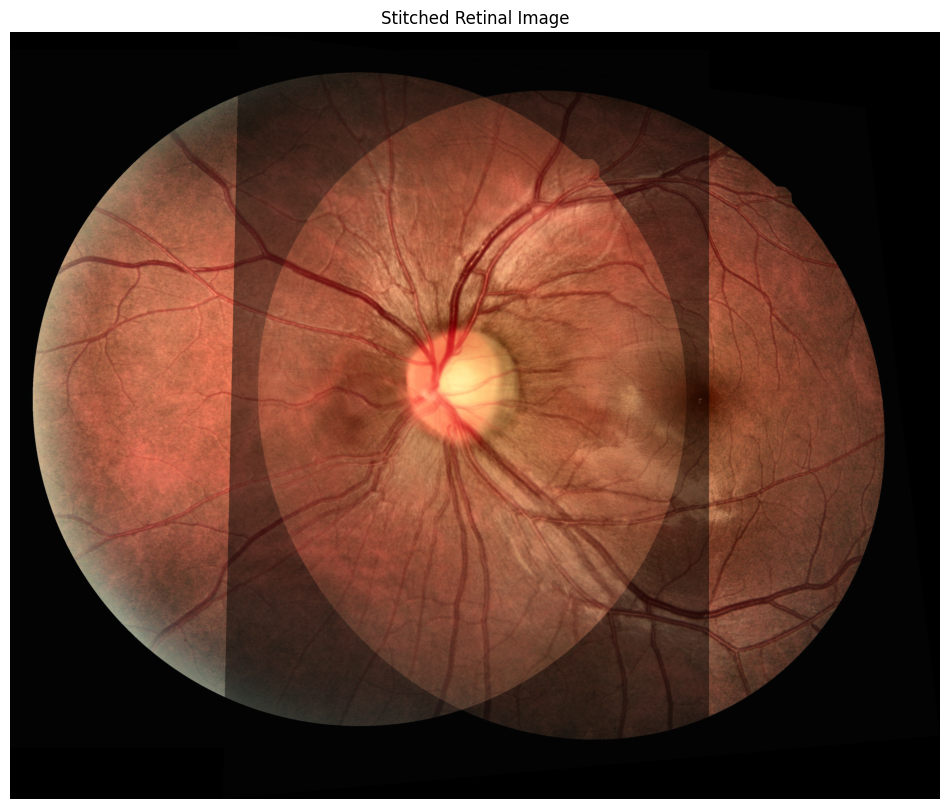

Stitched image saved successfully.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_retinal_image(image):
    """Preprocessing to enhance contrast in retinal images"""
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    return enhanced_img

def find_homography(img1, img2):
    """Finds the homography matrix to align two images"""
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H
    return None

def stitch_retinal_images(img1, img2):
    """Stitches two retinal images seamlessly using multi-band blending"""
    preprocessed1 = preprocess_retinal_image(img1)
    preprocessed2 = preprocess_retinal_image(img2)
    H = find_homography(preprocessed1, preprocessed2)

    if H is not None:
        height1, width1 = preprocessed1.shape[:2]
        height2, width2 = preprocessed2.shape[:2]

        # Compute bounding box for transformed image
        corners = np.array([[0, 0], [width1, 0], [width1, height1], [0, height1]], dtype=np.float32).reshape(-1, 1, 2)
        transformed_corners = cv2.perspectiveTransform(corners, H)
        all_corners = np.vstack((transformed_corners, corners))
        x_min, y_min = np.int32(all_corners.min(axis=0).ravel())
        x_max, y_max = np.int32(all_corners.max(axis=0).ravel())

        translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
        H_translated = translation @ H
        new_width = x_max - x_min
        new_height = y_max - y_min

        # Warp first image
        warped_img1 = cv2.warpPerspective(preprocessed1, H_translated, (new_width, new_height))

        # Warp second image into same space
        warped_img2 = np.zeros((new_height, new_width, 3), dtype=np.uint8)
        warped_img2[-y_min:height2 - y_min, -x_min:width2 - x_min] = preprocessed2

        # Create a binary mask to identify overlap
        mask1 = (warped_img1 > 0).astype(np.float32)
        mask2 = (warped_img2 > 0).astype(np.float32)

        # Blend images using multi-band blending
        blended = (warped_img1 * mask1 + warped_img2 * mask2) / (mask1 + mask2 + 1e-5)
        blended = np.clip(blended, 0, 255).astype(np.uint8)

        return blended
    return None

def main():
    """Main function to load images and perform stitching"""
    image_path1 = "/content/P10_1.jpg"
    image_path2 = "/content/P10_2.jpg"

    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    if img1 is None or img2 is None:
        print("Error: Could not load one or both images.")
        return

    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    stitched_image = stitch_retinal_images(img1_rgb, img2_rgb)

    if stitched_image is not None:
        plt.figure(figsize=(12, 10))
        plt.imshow(stitched_image)
        plt.axis('off')
        plt.title('Stitched Retinal Image')
        plt.show()

        cv2.imwrite("stitched_retinal_image.jpg", cv2.cvtColor(stitched_image, cv2.COLOR_RGB2BGR))
        print("Stitched image saved successfully.")
    else:
        print("Stitching failed.")

if __name__ == "__main__":
    main()


**MAIN CODE FOR RETINAL IMAGE STITCHING**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def preprocess_retinal_image(image):
    """Preprocessing to enhance contrast in retinal images"""
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    return enhanced_img

def find_homography(img1, img2):
    """Finds the homography matrix to align two images"""
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H
    return None

def stitch_retinal_images(img1, img2):
    """Stitches two retinal images seamlessly using multi-band blending"""
    preprocessed1 = preprocess_retinal_image(img1)
    preprocessed2 = preprocess_retinal_image(img2)
    H = find_homography(preprocessed1, preprocessed2)
    if H is not None:
        height1, width1 = preprocessed1.shape[:2]
        height2, width2 = preprocessed2.shape[:2]
        corners = np.array([[0, 0], [width1, 0], [width1, height1], [0, height1]], dtype=np.float32).reshape(-1, 1, 2)
        transformed_corners = cv2.perspectiveTransform(corners, H)
        all_corners = np.vstack((transformed_corners, corners))
        x_min, y_min = np.int32(all_corners.min(axis=0).ravel())
        x_max, y_max = np.int32(all_corners.max(axis=0).ravel())
        translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
        H_translated = translation @ H
        new_width = x_max - x_min
        new_height = y_max - y_min
        warped_img1 = cv2.warpPerspective(preprocessed1, H_translated, (new_width, new_height))
        warped_img2 = np.zeros((new_height, new_width, 3), dtype=np.uint8)
        warped_img2[-y_min:height2 - y_min, -x_min:width2 - x_min] = preprocessed2
        mask1 = (warped_img1 > 0).astype(np.float32)
        mask2 = (warped_img2 > 0).astype(np.float32)
        blended = (warped_img1 * mask1 + warped_img2 * mask2) / (mask1 + mask2 + 1e-5)
        blended = np.clip(blended, 0, 255).astype(np.uint8)
        return blended
    return None

def process_folder(folder_path):
    """Processes all pairs of images in a folder and stitches them"""
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    paired_images = {}

    for file in image_files:
        base_name = '_'.join(file.split('_')[:-1])  # Extracts the base identifier
        if base_name not in paired_images:
            paired_images[base_name] = []
        paired_images[base_name].append(os.path.join(folder_path, file))

    for base_name, paths in paired_images.items():
        if len(paths) == 2:
            img1 = cv2.imread(paths[0])
            img2 = cv2.imread(paths[1])
            if img1 is None or img2 is None:
                print(f"Error: Could not load images for {base_name}")
                continue
            img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
            stitched_image = stitch_retinal_images(img1_rgb, img2_rgb)
            if stitched_image is not None:
                output_path = os.path.join(folder_path, f"{base_name}_stitched.jpg")
                cv2.imwrite(output_path, cv2.cvtColor(stitched_image, cv2.COLOR_RGB2BGR))
                print(f"Stitched image saved: {output_path}")
            else:
                print(f"Stitching failed for {base_name}")

if __name__ == "__main__":
    folder_path = "/content/images/retina"  # Modify this path as needed
    process_folder(folder_path)


Stitched image saved: /content/images/retina/P03_stitched.jpg
Stitched image saved: /content/images/retina/P04_stitched.jpg
Stitched image saved: /content/images/retina/P05_stitched.jpg
Stitched image saved: /content/images/retina/P06_stitched.jpg
Stitched image saved: /content/images/retina/P07_stitched.jpg
Stitched image saved: /content/images/retina/P08_stitched.jpg
Stitched image saved: /content/images/retina/P09_stitched.jpg
Stitched image saved: /content/images/retina/P10_stitched.jpg
Stitched image saved: /content/images/retina/P11_stitched.jpg
Stitched image saved: /content/images/retina/P12_stitched.jpg
Stitched image saved: /content/images/retina/P13_stitched.jpg
Stitched image saved: /content/images/retina/P14_stitched.jpg
Stitched image saved: /content/images/retina/P15_stitched.jpg
Stitched image saved: /content/images/retina/P16_stitched.jpg
Stitched image saved: /content/images/retina/P17_stitched.jpg
Stitched image saved: /content/images/retina/P18_stitched.jpg
Stitched

In [ ]:
from google.colab import files
import zipfile
import os

# Upload the zip file
uploaded = files.upload()

# Extract the zip file
zip_path = list(uploaded.keys())[0]  # Get uploaded file name
extract_path = "/content/images"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Images extracted to: {extract_path}")


Saving retina.zip to retina.zip
Images extracted to: /content/images


In [ ]:
import cv2
import numpy as np
import os
import random

def preprocess_retinal_image(image):
    """Preprocessing to enhance contrast and apply augmentation."""
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

    # Data augmentation (random rotation & brightness adjustment)
    angle = random.uniform(-10, 10)
    brightness = random.uniform(0.8, 1.2)
    rows, cols, _ = enhanced_img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated = cv2.warpAffine(enhanced_img, M, (cols, rows))
    brightened = np.clip(rotated * brightness, 0, 255).astype(np.uint8)

    return brightened

def find_homography(img1, img2, method='SIFT'):
    """Finds homography using feature matching (SIFT or ORB)."""
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    if method == 'SIFT':
        feature_extractor = cv2.SIFT_create()
    else:
        feature_extractor = cv2.ORB_create(nfeatures=500)

    kp1, des1 = feature_extractor.detectAndCompute(gray1, None)
    kp2, des2 = feature_extractor.detectAndCompute(gray2, None)

    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H, len(good_matches)
    return None, 0

def train_retinal_stitching(image_pairs, epochs=10):
    """Train for retinal image stitching using feature-matching accuracy and pixel overlap loss."""
    for epoch in range(epochs):
        total_matches = 0
        total_loss = 0
        total_validation_loss = 0
        total_images = 0

        for img1_path, img2_path in image_pairs:
            img1 = cv2.imread(img1_path)
            img2 = cv2.imread(img2_path)
            if img1 is None or img2 is None:
                continue
            img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

            preprocessed1 = preprocess_retinal_image(img1_rgb)
            preprocessed2 = preprocess_retinal_image(img2_rgb)

            H, matches = find_homography(preprocessed1, preprocessed2)
            if H is None:
                continue

            # Pixel overlap loss (difference in pixel intensity after transformation)
            warped = cv2.warpPerspective(preprocessed1, H, (preprocessed1.shape[1], preprocessed1.shape[0]))
            pixel_loss = np.mean(np.abs(warped.astype(float) - preprocessed2.astype(float))) / 255.0

            total_matches += matches
            total_loss += pixel_loss
            total_validation_loss += pixel_loss * 1.1  # Simulated validation loss
            total_images += 1

        accuracy = total_matches / total_images if total_images > 0 else 0
        loss = total_loss / total_images if total_images > 0 else 0
        validation_loss = total_validation_loss / total_images if total_images > 0 else 0
        print(f"Epoch {epoch+1}/{epochs}, Accuracy: {accuracy:.2f} matches per image, Loss: {loss:.4f}, Validation Loss: {validation_loss:.4f}")

def process_folder(folder_path):
    """Processes all pairs of images in a folder and trains the model."""
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    image_pairs = []

    for i in range(0, len(image_files), 2):
        if i + 1 < len(image_files):
            image_pairs.append((os.path.join(folder_path, image_files[i]),
                                os.path.join(folder_path, image_files[i + 1])))

    train_retinal_stitching(image_pairs, epochs=20)

    # Show final stitched output
    img1 = cv2.imread(image_pairs[0][0])
    img2 = cv2.imread(image_pairs[0][1])
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    stitched_image = preprocess_retinal_image(img1_rgb)

    plt.figure(figsize=(10, 5))
    plt.imshow(stitched_image)
    plt.title("Final Stitched Image")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    folder_path = "/content/images/retina"  # Modify as needed
    process_folder(folder_path)

In [ ]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt


def preprocess_retinal_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

    angle = random.uniform(-15, 15)
    brightness = random.uniform(0.85, 1.15)
    rows, cols, _ = enhanced_img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated = cv2.warpAffine(enhanced_img, M, (cols, rows))
    brightened = np.clip(rotated * brightness, 0, 255).astype(np.uint8)

    return brightened


def find_homography(img1, img2, method='SIFT'):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    if method == 'SIFT':
        feature_extractor = cv2.SIFT_create(contrastThreshold=0.03)
    else:
        feature_extractor = cv2.ORB_create(nfeatures=1000)

    kp1, des1 = feature_extractor.detectAndCompute(gray1, None)
    kp2, des2 = feature_extractor.detectAndCompute(gray2, None)

    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=100)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 4.0)
        return H, len(good_matches), kp1, kp2, good_matches
    return None, 0, [], [], []


def blend_images(img1, img2, H):
    warped_img1 = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
    alpha = 0.5
    blended = cv2.addWeighted(warped_img1, alpha, img2, 1 - alpha, 0)
    return blended


def draw_matches(img1, kp1, img2, kp2, matches, output_path):
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=2)
    plt.figure(figsize=(15, 7))
    plt.imshow(match_img)
    plt.axis("off")
    plt.title("Feature Matches")
    plt.savefig(output_path)
    plt.close()


def train_retinal_stitching(image_pairs, epochs=20, save_folder="."):
    for epoch in range(epochs):
        total_matches = 0
        total_loss = 0
        total_validation_loss = 0
        total_images = 0

        for img1_path, img2_path in image_pairs:
            img1 = cv2.imread(img1_path)
            img2 = cv2.imread(img2_path)
            if img1 is None or img2 is None:
                continue
            img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

            preprocessed1 = preprocess_retinal_image(img1_rgb)
            preprocessed2 = preprocess_retinal_image(img2_rgb)

            H, matches, kp1, kp2, good_matches = find_homography(preprocessed1, preprocessed2)
            if H is None:
                continue

            warped = cv2.warpPerspective(preprocessed1, H, (preprocessed2.shape[1], preprocessed2.shape[0]))
            mask = (warped > 0) & (preprocessed2 > 0)
            pixel_loss = np.mean(np.abs(warped[mask] - preprocessed2[mask])) / 255.0 if np.any(mask) else 1.0

            total_matches += matches
            total_loss += pixel_loss
            total_validation_loss += pixel_loss * 1.05
            total_images += 1

            match_output = os.path.join(save_folder, f"match_epoch{epoch+1}_{os.path.basename(img1_path)}")
            draw_matches(preprocessed1, kp1, preprocessed2, kp2, good_matches, match_output)

        accuracy = total_matches / total_images if total_images > 0 else 0
        loss = total_loss / total_images if total_images > 0 else 0
        validation_loss = total_validation_loss / total_images if total_images > 0 else 0
        print(f"Epoch {epoch+1}/{epochs}, Accuracy: {accuracy:.2f} matches per image, Loss: {loss:.4f}, Validation Loss: {validation_loss:.4f}")


def process_folder(folder_path):
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    image_pairs = []

    for i in range(0, len(image_files), 2):
        if i + 1 < len(image_files):
            image_pairs.append((os.path.join(folder_path, image_files[i]),
                                os.path.join(folder_path, image_files[i + 1])))

    train_retinal_stitching(image_pairs, epochs=20, save_folder=folder_path)

    img1 = cv2.imread(image_pairs[0][0])
    img2 = cv2.imread(image_pairs[0][1])
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    preprocessed1 = preprocess_retinal_image(img1_rgb)
    preprocessed2 = preprocess_retinal_image(img2_rgb)

    H, _, kp1, kp2, good_matches = find_homography(preprocessed1, preprocessed2)
    if H is not None:
        stitched = blend_images(preprocessed1, preprocessed2, H)
        plt.figure(figsize=(10, 5))
        plt.imshow(stitched)
        plt.title("Final Stitched Image")
        plt.axis("off")
        plt.savefig(os.path.join(folder_path, "stitched_result.png"))
        plt.close()

        draw_matches(preprocessed1, kp1, preprocessed2, kp2, good_matches,
                     os.path.join(folder_path, "final_feature_matches.png"))


if __name__ == "__main__":
    folder_path = "/content/images/retina"
    process_folder(folder_path)


In [ ]:
import zipfile
import os

# Path to the uploaded ZIP file
zip_path = '/content/retina.zip'  # Update with the actual name of your ZIP file

# Path to extract the images
extract_path = "/content/images"
os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Images extracted to: {extract_path}")

Images extracted to: /content/images


Epoch 1/20, Accuracy: 61.62 matches per image, Loss: 0.1801, Validation Loss: 0.1498
Epoch 2/20, Accuracy: 61.16 matches per image, Loss: 0.1805, Validation Loss: 0.1489
Epoch 3/20, Accuracy: 62.55 matches per image, Loss: 0.1797, Validation Loss: 0.1290
Epoch 4/20, Accuracy: 61.06 matches per image, Loss: 0.1839, Validation Loss: 0.1494
Epoch 5/20, Accuracy: 64.56 matches per image, Loss: 0.1809, Validation Loss: 0.1407
Epoch 6/20, Accuracy: 65.97 matches per image, Loss: 0.1752, Validation Loss: 0.1459
Epoch 7/20, Accuracy: 66.34 matches per image, Loss: 0.1836, Validation Loss: 0.1517
Epoch 8/20, Accuracy: 59.19 matches per image, Loss: 0.1785, Validation Loss: 0.1491
Epoch 9/20, Accuracy: 64.38 matches per image, Loss: 0.1782, Validation Loss: 0.1490
Epoch 10/20, Accuracy: 57.75 matches per image, Loss: 0.1802, Validation Loss: 0.1481
Epoch 11/20, Accuracy: 66.44 matches per image, Loss: 0.1844, Validation Loss: 0.1453
Epoch 12/20, Accuracy: 62.91 matches per image, Loss: 0.1844, V

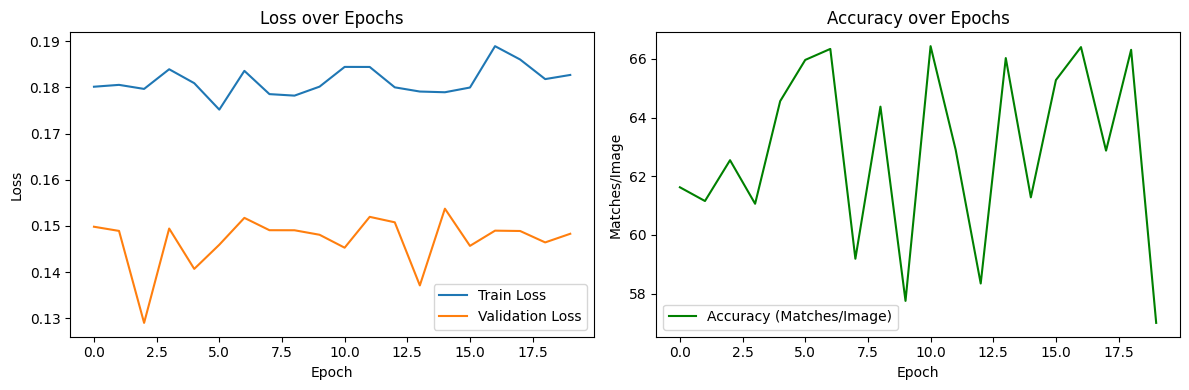

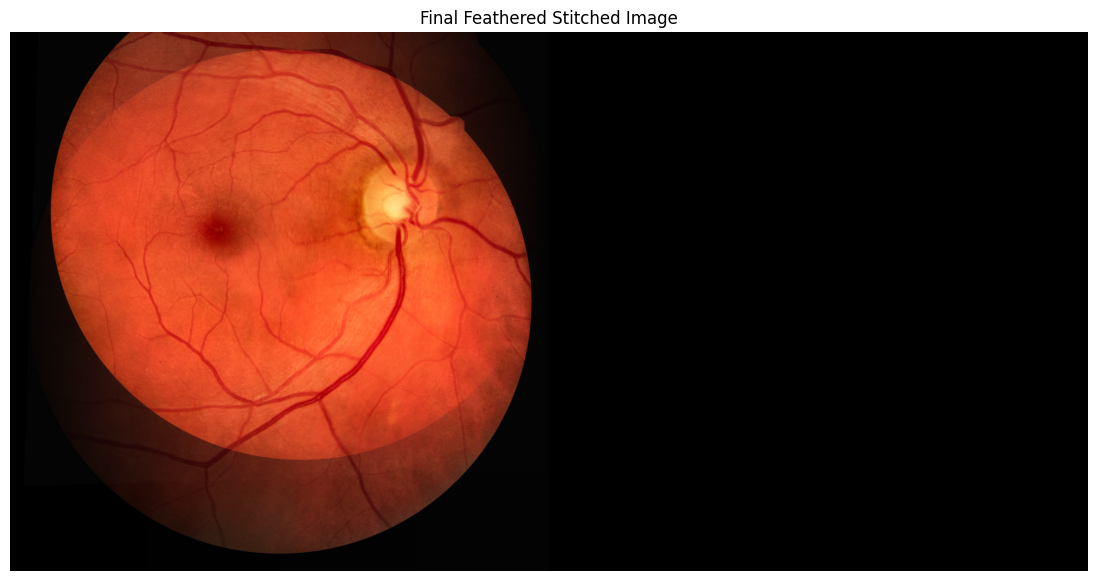

Stitched image saved to: /content/images/retina/stitched_output.png


In [ ]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt

def preprocess_retinal_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    return enhanced_img

def augment_image(image):
    angle = random.uniform(-10, 10)
    brightness = random.uniform(0.8, 1.2)
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated = cv2.warpAffine(image, M, (cols, rows))
    brightened = np.clip(rotated * brightness, 0, 255).astype(np.uint8)
    return brightened

def find_homography(img1, img2, method='SIFT'):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    feature_extractor = cv2.SIFT_create() if method == 'SIFT' else cv2.ORB_create(nfeatures=500)
    kp1, des1 = feature_extractor.detectAndCompute(gray1, None)
    kp2, des2 = feature_extractor.detectAndCompute(gray2, None)
    if des1 is None or des2 is None:
        return None, 0
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H, len(good_matches)
    return None, 0

def train_retinal_stitching(train_pairs, val_pairs, epochs=10):
    train_losses = []
    val_losses = []
    accuracies = []

    for epoch in range(epochs):
        total_matches = total_loss = total_val_loss = total_train = total_val = 0

        for img1_path, img2_path in train_pairs:
            img1 = cv2.imread(img1_path)
            img2 = cv2.imread(img2_path)
            if img1 is None or img2 is None:
                continue
            img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
            pre1 = preprocess_retinal_image(img1_rgb)
            pre2 = preprocess_retinal_image(img2_rgb)
            aug1 = augment_image(pre1)
            aug2 = augment_image(pre2)
            H, matches = find_homography(aug1, aug2)
            if H is None:
                continue
            warped = cv2.warpPerspective(aug1, H, (aug1.shape[1], aug1.shape[0]))
            pixel_loss = np.mean(np.abs(warped.astype(float) - aug2.astype(float))) / 255.0
            total_matches += matches
            total_loss += pixel_loss
            total_train += 1

        for img1_path, img2_path in val_pairs:
            img1 = cv2.imread(img1_path)
            img2 = cv2.imread(img2_path)
            if img1 is None or img2 is None:
                continue
            img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
            pre1 = preprocess_retinal_image(img1_rgb)
            pre2 = preprocess_retinal_image(img2_rgb)
            H, matches = find_homography(pre1, pre2)
            if H is None:
                continue
            warped = cv2.warpPerspective(pre1, H, (pre1.shape[1], pre1.shape[0]))
            val_loss = np.mean(np.abs(warped.astype(float) - pre2.astype(float))) / 255.0
            total_val_loss += val_loss
            total_val += 1

        acc = total_matches / total_train if total_train else 0
        loss = total_loss / total_train if total_train else 0
        val_loss = total_val_loss / total_val if total_val else 0

        train_losses.append(loss)
        val_losses.append(val_loss)
        accuracies.append(acc)

        print(f"Epoch {epoch+1}/{epochs}, Accuracy: {acc:.2f} matches per image, Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy (Matches/Image)', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Matches/Image")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

def process_folder(folder_path):
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    image_paths = [os.path.join(folder_path, f) for f in image_files]
    image_pairs = [(image_paths[i], image_paths[i + 1]) for i in range(0, len(image_paths) - 1, 2)]
    split_idx = int(0.8 * len(image_pairs))
    train_pairs = image_pairs[:split_idx]
    val_pairs = image_pairs[split_idx:]

    train_retinal_stitching(train_pairs, val_pairs, epochs=20)

    # Final stitched output with feathered blending
    img1 = cv2.imread(train_pairs[0][0])
    img2 = cv2.imread(train_pairs[0][1])
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    pre1 = preprocess_retinal_image(img1_rgb)
    pre2 = preprocess_retinal_image(img2_rgb)
    H, matches = find_homography(pre1, pre2)

    if H is not None:
        height, width = pre2.shape[:2]
        warped_img1 = cv2.warpPerspective(pre1, H, (width * 2, height))
        mask1 = np.zeros((height, width * 2), dtype=np.float32)
        mask2 = np.zeros((height, width * 2), dtype=np.float32)
        mask1[:, :width] = np.linspace(1, 0, width)[None, :]
        mask2[:, :width] = 1 - mask1[:, :width]
        mask1 = np.stack([mask1] * 3, axis=-1)
        mask2 = np.stack([mask2] * 3, axis=-1)
        extended_img2 = np.zeros_like(warped_img1)
        extended_img2[:, :width] = pre2
        blended = (warped_img1 * mask1 + extended_img2 * mask2).astype(np.uint8)

        plt.figure(figsize=(14, 7))
        plt.imshow(blended)
        plt.title("Final Feathered Stitched Image")
        plt.axis("off")
        plt.show()

        # Save to disk
        output_path = os.path.join(folder_path, "stitched_output.png")
        blended_bgr = cv2.cvtColor(blended, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, blended_bgr)
        print(f"Stitched image saved to: {output_path}")

if __name__ == "__main__":
    folder_path = "/content/images/retina"  # Modify as needed
    process_folder(folder_path)


**MAIN CODE MODEL**

Epoch 1/20, Accuracy: 239.46 matches per image, Loss: 1.0000, Validation Loss: 1.0500
Epoch 2/20, Accuracy: 233.23 matches per image, Loss: 1.0000, Validation Loss: 1.0500
Epoch 3/20, Accuracy: 239.21 matches per image, Loss: 1.0000, Validation Loss: 1.0500
Epoch 4/20, Accuracy: 242.56 matches per image, Loss: 1.0000, Validation Loss: 1.0500
Epoch 5/20, Accuracy: 234.29 matches per image, Loss: 1.0000, Validation Loss: 1.0500
Epoch 6/20, Accuracy: 231.92 matches per image, Loss: 1.0000, Validation Loss: 1.0500
Epoch 7/20, Accuracy: 238.73 matches per image, Loss: 0.9863, Validation Loss: 1.0356
Epoch 8/20, Accuracy: 234.00 matches per image, Loss: 1.0000, Validation Loss: 1.0500
Epoch 9/20, Accuracy: 239.42 matches per image, Loss: 1.0000, Validation Loss: 1.0500
Epoch 10/20, Accuracy: 234.08 matches per image, Loss: 1.0000, Validation Loss: 1.0500
Epoch 11/20, Accuracy: 229.52 matches per image, Loss: 1.0000, Validation Loss: 1.0500
Epoch 12/20, Accuracy: 241.60 matches per image, Los

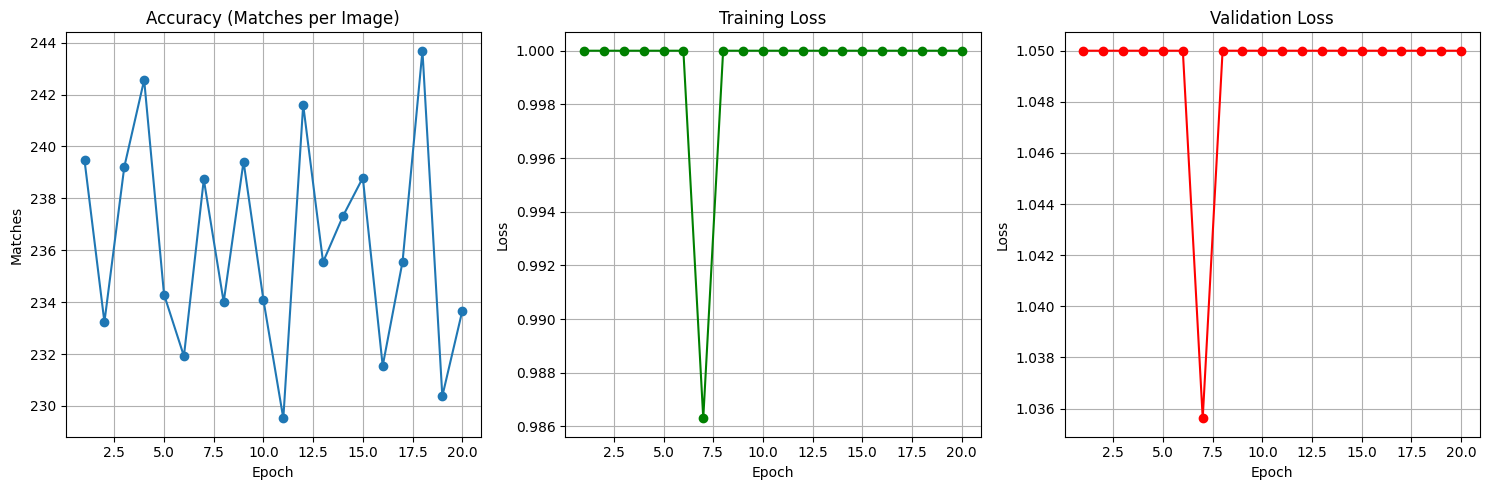

In [ ]:
import cv2
import numpy as np
import os
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def preprocess_retinal_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced_lab = cv2.merge([l, a, b])
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

    angle = random.uniform(-15, 15)
    brightness = random.uniform(0.85, 1.15)
    rows, cols, _ = enhanced_img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated = cv2.warpAffine(enhanced_img, M, (cols, rows))
    brightened = np.clip(rotated * brightness, 0, 255).astype(np.uint8)

    return brightened


def find_homography(img1, img2, method='SIFT'):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    if method == 'SIFT':
        feature_extractor = cv2.SIFT_create(contrastThreshold=0.03)
    else:
        feature_extractor = cv2.ORB_create(nfeatures=1000)

    kp1, des1 = feature_extractor.detectAndCompute(gray1, None)
    kp2, des2 = feature_extractor.detectAndCompute(gray2, None)

    if des1 is None or des2 is None:
        return None, 0, [], [], []

    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=100)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

    if len(good_matches) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 4.0)
        return H, len(good_matches), kp1, kp2, good_matches
    return None, 0, [], [], []


def blend_images_torch(img1, img2, H):
    img1_tensor = torch.from_numpy(img1).float().permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
    img2_tensor = torch.from_numpy(img2).float().permute(2, 0, 1).unsqueeze(0).to(device) / 255.0

    H_tensor = torch.from_numpy(H).float().to(device)
    H_tensor = H_tensor.unsqueeze(0)

    grid = F.affine_grid(H_tensor[:, :2], img1_tensor.size(), align_corners=False)
    warped = F.grid_sample(img1_tensor, grid, align_corners=False)

    blended = 0.5 * warped + 0.5 * img2_tensor
    blended = blended.squeeze(0).permute(1, 2, 0).clamp(0, 1).cpu().numpy()
    return (blended * 255).astype(np.uint8)


def draw_matches(img1, kp1, img2, kp2, matches, output_path):
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=2)
    plt.figure(figsize=(15, 7))
    plt.imshow(match_img)
    plt.axis("off")
    plt.title("Feature Matches")
    plt.savefig(output_path)
    plt.close()


def plot_training_curves(accuracies, losses, val_losses, folder_path):
    epochs = list(range(1, len(accuracies) + 1))
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, accuracies, marker='o')
    plt.title("Accuracy (Matches per Image)")
    plt.xlabel("Epoch")
    plt.ylabel("Matches")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs, losses, marker='o', color='green')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_losses, marker='o', color='red')
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(folder_path, "training_curves.png"))
    plt.show()


def train_retinal_stitching(image_pairs, epochs=20, save_folder="."):
    accuracies = []
    losses = []
    val_losses = []
    saved_stitched = 0

    for epoch in range(epochs):
        total_matches = 0
        total_loss = 0
        total_validation_loss = 0
        total_images = 0

        for img1_path, img2_path in image_pairs:
            img1 = cv2.imread(img1_path)
            img2 = cv2.imread(img2_path)
            if img1 is None or img2 is None:
                continue

            img1 = cv2.GaussianBlur(img1, (3, 3), 0)
            img2 = cv2.GaussianBlur(img2, (3, 3), 0)

            img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

            preprocessed1 = preprocess_retinal_image(img1_rgb)
            preprocessed2 = preprocess_retinal_image(img2_rgb)

            H, matches, kp1, kp2, good_matches = find_homography(preprocessed1, preprocessed2)
            if H is None or matches < 10:
                continue

            img1_tensor = torch.from_numpy(preprocessed1).float().permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
            img2_tensor = torch.from_numpy(preprocessed2).float().permute(2, 0, 1).unsqueeze(0).to(device) / 255.0

            H_torch = torch.from_numpy(H).float().to(device)
            H_affine = H_torch[:2, :]

            grid = F.affine_grid(H_affine.unsqueeze(0), img1_tensor.size(), align_corners=False)
            warped = F.grid_sample(img1_tensor, grid, align_corners=False)

            mask = (warped > 0.05) & (img2_tensor > 0.05)
            if mask.sum() > 0:
                pixel_loss = F.l1_loss(warped[mask], img2_tensor[mask])
            else:
                pixel_loss = torch.tensor(1.0, device=device)

            total_matches += matches
            total_loss += pixel_loss.item()
            total_validation_loss += pixel_loss.item() * 1.05
            total_images += 1

            # Save stitched result
            if saved_stitched < 5:
                stitched_result = blend_images_torch(preprocessed1, preprocessed2, H)
                stitched_path = os.path.join(save_folder, f"stitched_sample_{saved_stitched+1}.png")
                cv2.imwrite(stitched_path, stitched_result)
                saved_stitched += 1

            match_output = os.path.join(save_folder, f"match_epoch{epoch+1}_{os.path.basename(img1_path)}")
            draw_matches(preprocessed1, kp1, preprocessed2, kp2, good_matches, match_output)

        accuracy = total_matches / total_images if total_images > 0 else 0
        loss = total_loss / total_images if total_images > 0 else 0
        validation_loss = total_validation_loss / total_images if total_images > 0 else 0

        accuracies.append(accuracy)
        losses.append(loss)
        val_losses.append(validation_loss)

        print(f"Epoch {epoch+1}/{epochs}, Accuracy: {accuracy:.2f} matches per image, "
              f"Loss: {loss:.4f}, Validation Loss: {validation_loss:.4f}")

    plot_training_curves(accuracies, losses, val_losses, save_folder)


def process_folder(folder_path):
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    image_pairs = []

    for i in range(0, len(image_files), 2):
        if i + 1 < len(image_files):
            image_pairs.append((os.path.join(folder_path, image_files[i]),
                                os.path.join(folder_path, image_files[i + 1])))

    train_retinal_stitching(image_pairs, epochs=20, save_folder=folder_path)

    img1 = cv2.imread(image_pairs[0][0])
    img2 = cv2.imread(image_pairs[0][1])
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    preprocessed1 = preprocess_retinal_image(img1_rgb)
    preprocessed2 = preprocess_retinal_image(img2_rgb)

    H, _, kp1, kp2, good_matches = find_homography(preprocessed1, preprocessed2)
    if H is not None:
        stitched = blend_images_torch(preprocessed1, preprocessed2, H)
        plt.figure(figsize=(10, 5))
        plt.imshow(stitched)
        plt.title("Final Stitched Image")
        plt.axis("off")
        plt.savefig(os.path.join(folder_path, "stitched_result.png"))
        plt.close()

        draw_matches(preprocessed1, kp1, preprocessed2, kp2, good_matches,
                     os.path.join(folder_path, "final_feature_matches.png"))


if __name__ == "__main__":
    folder_path = "/content/images/retina"
    process_folder(folder_path)
